# BBC News NLP
An analysis of BBC News articles, using NLP. [Data is available here](http://mlg.ucd.ie/datasets/bbc.html).

Objectives:
* Use the full text dataset and classify each existing category into sub-categories: 
    * Breakdown ‘Business’ into stock market, company news, mergers and acquisitions etc. 
    * Breakdown ‘Entertainment’ into cinema, theatre, music, literature, personality etc. 
    * Breakdown ‘Sports’ into the type of sport: cricket, football, Olympics etc. 
    * Please create as many categories as you feel are appropriate. 
* Identify documents and extract the named entities for media personalities, clearly identifying their jobs (e.g. Politicians, TV/Film Personalities, Musicians)
* Extract summaries of anything that took place or is/was scheduled to take place in April.

In [2]:
# Load Libraries
import pandas as pd
import re
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer as WNL
from nltk.corpus import wordnet
from string import punctuation
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from transformers import pipeline
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import spacy
from spacy.matcher import PhraseMatcher
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define stopwords
stopwords_list = stopwords.words("english")
stopwords_list = [*stopwords_list, *list(punctuation), *['``', "''"]]


In [3]:
# Load the files
parent_folder = "C:\\Users\\User\\Documents\\Projects\\BBC_News_NLP\\Data\\bbc"

# Collect each category's filepath
category_folders = [] 
for folder in os.listdir(parent_folder):
    path = os.path.join(parent_folder, folder)
    if os.path.isdir(path): # Check it is a filepath (e.g. not a README)
        category_folders.append(path)

# Identify, read and collate the .txt files within each category folder 
articles_list = [] 
for category in category_folders:
    for article in os.listdir(category):
        if article.endswith(".txt") and not article.startswith("README"): # only select relevant .txt files
            article_path = os.path.join(category, article)
            try: 
                with open(article_path, "r") as file:
                    article_text = file.read()
                        # append articles to list, noting the article category:
                    articles_list.append({"text" : article_text, "category" : os.path.relpath(category, parent_folder)})
            except: 
                print(f"Could not load {article_path}")

articles = pd.DataFrame(articles_list) # convert the articles into a dataframe

# Print the numbers of articles, and the first few rows of the data
print(f"{len(articles)} articles loaded") 
articles.head()

2225 articles loaded


,text,category
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [4]:
# Check for and remove any duplicate rows
print(articles[articles.duplicated()].head())
print(f"{len(articles[articles.duplicated()])} duplicated rows") #98 duplicate rows

articles = articles.drop_duplicates()

                                                  text  category
239  Economy 'strong' in election year\n\nUK busine...  business
252  Jobs growth still slow in the US\n\nThe US cre...  business
332  Troubled Marsh under SEC scrutiny\n\nThe US st...  business
355  S Korea spending boost to economy\n\nSouth Kor...  business
370  Singapore growth at 8.1% in 2004\n\nSingapore'...  business
98 duplicated rows


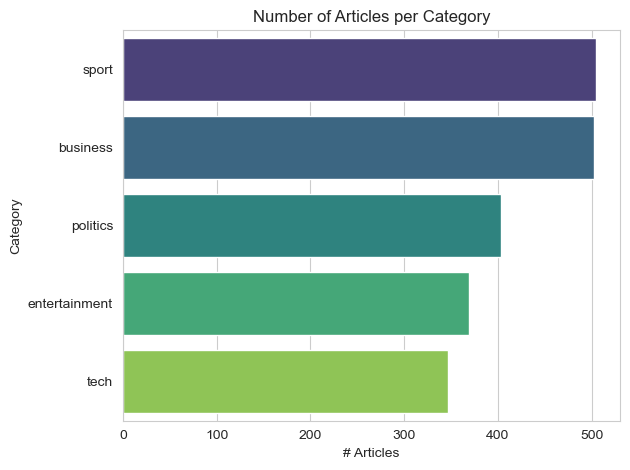

In [99]:
# Visualise the number of articles per category:
sns.countplot(data=articles, y="category", order=articles["category"].value_counts().index, palette="viridis")
plt.title("Number of Articles per Category")
plt.xlabel("# Articles")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

In [115]:
# Define functions to count the number of words, sentences, and stop words for each row:
def count_words(text):
    if not isinstance(text, str):
        return 0 # Handle non-string values
    words = word_tokenize(text) # Convert text to a list of words
    return len(words) #return number of words

def count_sentences(text): # Repeat for sentences
    if not isinstance(text, str):
        return 0
    sentences = sent_tokenize(text)
    return len(sentences)

def count_stopwords(text): # Repeat for number of stop words
    if not isinstance(text, str): 
        return 0
    words = word_tokenize(text.lower()) 
    stopword_count = sum(1 for word in words if word in stopwords_list)
    return stopword_count

# Apply to each article
articles["num_words"] = articles["text"].apply(count_words).round(2)
articles["num_sentences"] = articles["text"].apply(count_sentences)
articles["num_stopwords"] = articles["text"].apply(count_stopwords)

# Calculate averages per category
averages_per_category = articles.groupby("category")[["num_sentences", "num_words", "num_stopwords"]].mean().reset_index().round(2)

# Rename columns
averages_per_category.rename(columns={
    "num_sentences": "Average Sentences",
    "num_words": "Average Words",
    "num_stopwords": "Average Stop Words"
}, inplace=True)

print("Average metrics per category:\n", averages_per_category)

Average metrics per category:
         category  Average Sentences  Average Words  Average Stop Words
0       business              15.68         376.74              172.52
1  entertainment              16.49         382.27              179.56
2       politics              21.03         517.36              254.71
3          sport              17.16         382.39              190.38
4           tech              24.60         577.88              280.12


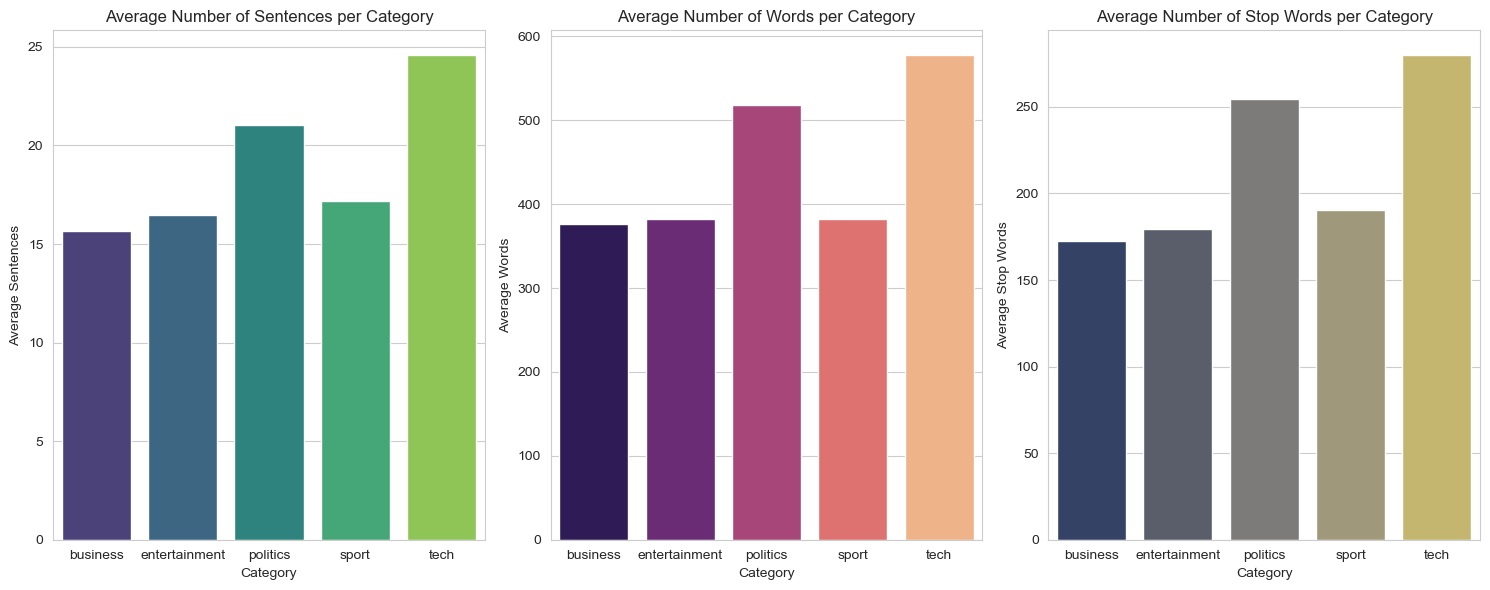

In [127]:
#Plot average sentences, words and stop words per category

plt.figure(figsize=(15, 6))

# Average Sentences
plt.subplot(1, 3, 1) 
sns.barplot(x="category", y="Average Sentences", data=averages_per_category, palette="viridis")
plt.title("Average Number of Sentences per Category")
plt.xlabel("Category")
plt.ylabel("Average Sentences")

# Average Words per Category
plt.subplot(1, 3, 2) 
sns.barplot(x="category", y="Average Words", data=averages_per_category, palette="magma")
plt.title("Average Number of Words per Category")
plt.xlabel("Category")
plt.ylabel("Average Words")

# Average Stop Words per Category
plt.subplot(1, 3, 3)
sns.barplot(x="category", y="Average Stop Words", data=averages_per_category, palette="cividis")
plt.title("Average Number of Stop Words per Category")
plt.xlabel("Category")
plt.ylabel("Average Stop Words")

plt.tight_layout()
plt.show()

## Processing the data:
Define a function to pre-process sentences using tokenisation, POS-tagging, lemmatisation, and removing stop-words, and a function to convert POS-tags to the format used by WNL:

In [9]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

def preprocess_sentence(input_text):
    tagged_text = []
    for word, tag in pos_tag(word_tokenize(input_text)):
        tagged_text.append((word, get_wordnet_pos(tag)))
        
    lemma_text = [WNL().lemmatize(word.lower(), pos=tag) for word, tag in tagged_text]
    processed_text = [word for word in lemma_text if word not in stopwords_list and not word.isdigit()]
    return processed_text

In [10]:
# Apply to the actricles in the dataset
articles["cleaned_text"] = articles["text"].apply(lambda x: " ".join(preprocess_sentence(x)))
articles.head()

,text,category,num_words,num_sentences,num_stopwords,cleaned_text
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,490,20,164,ad sale boost time warner profit quarterly pro...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,433,15,153,dollar gain greenspan speech dollar hit high l...
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,294,12,105,yukos unit buyer face loan claim owner embattl...
3,High fuel prices hit BA's profits\n\nBritish A...,business,472,19,136,high fuel price hit ba 's profit british airwa...
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,306,12,94,pernod takeover talk lift domecq share uk drin...


We can also use TextRank summarisation to simplify the articles. TextRank has been chosen as it balances a greater complexity than traditional summarisation against the much higher computational costs of abstract summarisation (and the risks associated with generative extraction by the latter).

In [129]:
text_rank_summarizer = TextRankSummarizer()
def textRank_summary(text, n=2):
    try:
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summary = text_rank_summarizer(parser.document, sentences_count=n)
        return " ".join(str(sentence) for sentence in summary)
    except Exception as e:
        return ""

articles["textRank_summary"] = articles["text"].apply(textRank_summary)

articles.head()

,text,category,num_words,num_sentences,num_stopwords,cleaned_text,textRank_summary
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,490,20,229,ad sale boost time warner profit quarterly pro...,But its film division saw profits slump 27% to...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,433,15,194,dollar gain greenspan speech dollar hit high l...,"In the meantime, the US Federal Reserve's deci..."
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,294,12,133,yukos unit buyer face loan claim owner embattl...,The owners of embattled Russian oil giant Yuko...
3,High fuel prices hit BA's profits\n\nBritish A...,business,472,19,201,high fuel price hit ba 's profit british airwa...,Looking ahead to its full year results to Marc...
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,306,12,132,pernod takeover talk lift domecq share uk drin...,Shares in UK drinks and food firm Allied Domec...


## Subject Classification
As this data is unlabelled, unsupervised learning techniques will be used to estimate the topics within each broader category.

Let's focus on just the sports articles:

In [14]:
sports_articles = articles[articles["category"] == "sport"].copy()

sports_articles.head()

,text,category,num_words,num_sentences,num_stopwords,cleaned_text,textRank_summary
1313,Claxton hunting first major medal\n\nBritish h...,sport,235,11,85,claxton hunt first major medal british hurdler...,The 25-year-old has already smashed the Britis...
1314,O'Sullivan could run in Worlds\n\nSonia O'Sull...,sport,158,7,52,o'sullivan could run world sonia o'sullivan in...,Athletics Ireland have hinted that the 35-year...
1315,Greene sets sights on world title\n\nMaurice G...,sport,435,23,183,greene set sight world title maurice greene ai...,"""I believe that's what put me in lane seven in..."
1316,IAAF launches fight against drugs\n\nThe IAAF ...,sport,226,9,87,iaaf launch fight drug iaaf athletics world go...,The IAAF - athletics' world governing body - h...
1317,"Dibaba breaks 5,000m world record\n\nEthiopia'...",sport,192,10,61,"dibaba break 5,000m world record ethiopia 's t...",Ethiopia's Tirunesh Dibaba set a new world rec...


There are three broad approaches, topic modelling (such as NMF and LDA), rule-based labelling, or clustering.
* Topic modelling aims to group the articles into similar 'hidden' topics, and returns key-words so they can be labelled.
* Rule-based labelling searches for pre-defined labels, which is fast but requires effective and comprehensive domain knowledge.
* Clustering vectorises each article and then groups based on similarity. This can be fast, but also less interpretable than others.
* Alternatively:
    * Zero-shot classification can also be used, which uses an already trained model to assign probabilistic labels to articles. However this can lack nuance as it is trained on external datasets, and can still be computationally expensive.
    * If enough articles can be labelled, it may also be possible to use supervised machine learning 



In [147]:
# Convert the articles into a 'bags-of-words', count frequencies, and translate to a vector
count_vector = CountVectorizer(min_df=0.05, max_df=0.9)
vectorised = count_vector.fit_transform(sports_articles["cleaned_text"])
features = count_vector.get_feature_names_out()

In [17]:
# Define a functon to print top phrases per identified topic
def get_top_keywords(model, feature_names, n_top_words=10):
    keywords = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        keywords.append(top_features)
    return keywords

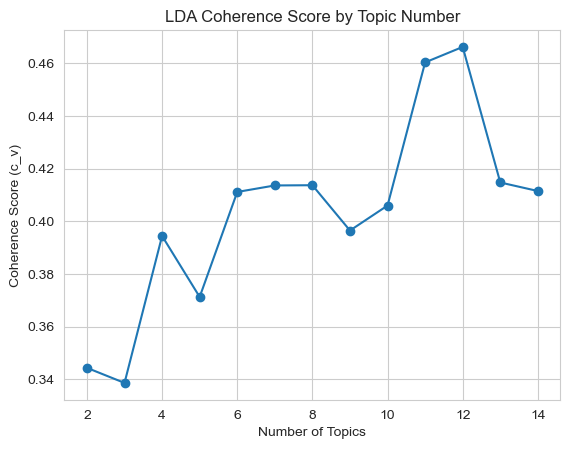

In [18]:
# Calculate optimal number of topics for LDA by plotting coherence score
texts = sports_articles["cleaned_text"].apply(lambda x: x.split()) # tokenise and split out words
dictionary = corpora.Dictionary(texts) # creates an ID'ed dictionary of the words
corpus = [dictionary.doc2bow(text) for text in texts] # Converts to a bag-of-words

coherence_values = []
topic_range = range(2, 15) # check for between 2 and 14 topics

for num_topics in topic_range: # train a model for each number of topics and extract coherence score
    model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=50)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
    coherence_values.append(coherencemodel.get_coherence())

plt.plot(topic_range, coherence_values, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("LDA Coherence Score by Topic Number")
plt.grid(True)
plt.show()

In [19]:
# Perform LDA using 12 topics
lda_model = LatentDirichletAllocation(n_components=12, random_state=50)
lda_topics = lda_model.fit_transform(vectorised)
sports_articles["LDA_topic"] = lda_topics.argmax(axis=1) # Assign each articles to it's identified topic

# Extract and print top keywords per topic
lda_keywords = get_top_keywords(lda_model, features) 
for i, topic in enumerate(lda_keywords): 
    print(f"Topic {i}: {", ".join(topic)}")

Topic 0: england, robinson, rugby, six, game, nation, andy, sale, say, matt
Topic 1: ireland, wale, game, france, half, win, england, italy, try, side
Topic 2: set, win, match, play, break, game, say, final, first, beat
Topic 3: referee, kick, ball, get, united, go, take, say, two, could
Topic 4: minute, goal, half, penalty, score, second, lead, time, ball, first
Topic 5: test, say, drug, ban, charge, take, also, miss, athens, year
Topic 6: say, club, would, game, play, player, go, chelsea, league, liverpool
Topic 7: world, win, year, second, race, title, final, time, champion, record
Topic 8: player, say, play, england, rugby, injury, year, coach, cup, back
Topic 9: new, zealand, tour, lion, match, australia, deal, first, team, leave
Topic 10: open, win, year, say, play, round, first, australian, last, injury
Topic 11: athletics, say, athlete, run, would, olympic, year, go, athens, medal


In [20]:
# label these topics
LDA_labels = {
    0 : "Rugby",
    1 : "Rugby",
    2 : "Tennis",
    3 : "Football",
    4 : "Football",
    5 : "Olympics/Athletics",
    6 : "Football",
    7 : "Olympics/Athletics",
    8 : "Rugby",
    9 : "Rugby",
    10 : "Golf",
    11 : "Olympics/Athletics"}

sports_articles["LDA_topic"] = sports_articles["LDA_topic"].map(LDA_labels)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


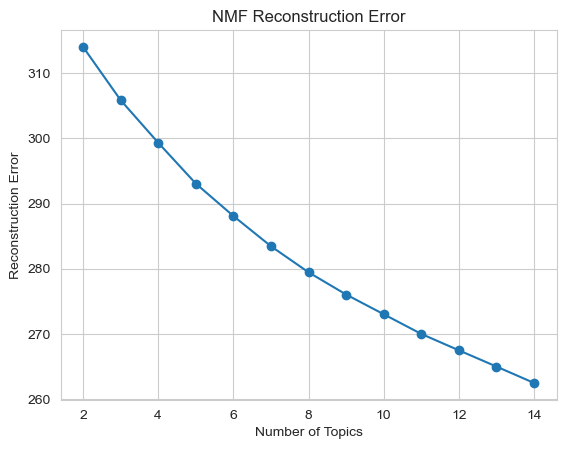

In [21]:
# Calculate optimal n for NMF: 
recon_errors = []
topic_range = range(2, 15)

for k in topic_range: # Train an NMF model for between 2 and 14 topics
    model = NMF(n_components=k, random_state=50)
    W = model.fit_transform(vectorised)
    H = model.components_
    recon_error = model.reconstruction_err_
    recon_errors.append(recon_error)

plt.plot(topic_range, recon_errors, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Reconstruction Error")
plt.title("NMF Reconstruction Error")
plt.grid(True)
plt.show()

In [22]:
#Perform NMF, looking for 6 topics (as the marginal gain starts to decrease at 6, and we want to avoid overfitting)
nmf_model = NMF(n_components=6, random_state=50)
nmf_topics = nmf_model.fit_transform(vectorised)
sports_articles["NMF_topic"] = nmf_topics.argmax(axis=1)

# Extract and print top keywords per topic
nmf_keywords = get_top_keywords(nmf_model, features)
for i, topic in enumerate(nmf_keywords):
    print(f"Topic {i}: {", ".join(topic)}")

Topic 0: england, six, ireland, france, nation, play, robinson, game, say, coach
Topic 1: say, would, club, liverpool, player, go, want, think, get, make
Topic 2: year, win, world, second, champion, title, time, say, final, best
Topic 3: new, zealand, wale, game, win, first, rugby, team, tour, side
Topic 4: game, point, set, break, serve, hold, first, match, go, two
Topic 5: minute, half, try, penalty, ireland, goal, ball, second, lead, time


In [23]:
# Assign estimated labels
NMF_labels = {
    0 : "Rugby",
    1 : "Football",
    2 : "Olympics/Athletics",
    3 : "Rugby",
    4 : "Tennis",
    5 : "Rugby"}

sports_articles["NMF_topic"] = sports_articles["NMF_topic"].map(NMF_labels)

In [24]:
sports_articles.head()

,text,category,num_words,num_sentences,num_stopwords,cleaned_text,textRank_summary,LDA_topic,NMF_topic
1313,Claxton hunting first major medal\n\nBritish h...,sport,235,11,85,claxton hunt first major medal british hurdler...,The 25-year-old has already smashed the Britis...,Olympics/Athletics,Olympics/Athletics
1314,O'Sullivan could run in Worlds\n\nSonia O'Sull...,sport,158,7,52,o'sullivan could run world sonia o'sullivan in...,Athletics Ireland have hinted that the 35-year...,Olympics/Athletics,Olympics/Athletics
1315,Greene sets sights on world title\n\nMaurice G...,sport,435,23,183,greene set sight world title maurice greene ai...,"""I believe that's what put me in lane seven in...",Olympics/Athletics,Olympics/Athletics
1316,IAAF launches fight against drugs\n\nThe IAAF ...,sport,226,9,87,iaaf launch fight drug iaaf athletics world go...,The IAAF - athletics' world governing body - h...,Olympics/Athletics,Football
1317,"Dibaba breaks 5,000m world record\n\nEthiopia'...",sport,192,10,61,"dibaba break 5,000m world record ethiopia 's t...",Ethiopia's Tirunesh Dibaba set a new world rec...,Olympics/Athletics,Olympics/Athletics


In [133]:
# Rule based matching to identify keywords and evaluate:
nlp = spacy.load("en_core_web_sm")

# Define sports keywords to look for
sports = ["cricket", "football", "rugby", "tennis", "nba", "formula one", "f1", "olympics", "athletics", "golf", "boxing", "basketball", "darts"]
patterns = [nlp.make_doc(sport) for sport in sports]
matcher = PhraseMatcher(nlp.vocab)
matcher.add("SPORTS", patterns)

def detect_sport(text):
    doc = nlp(text.lower())
    matches = matcher(doc)
    matched = list(set([doc[start:end].text for _, start, end in matches]))
    return matched[0] if matched else "unknown"

# Apply keyword-categorisation where possible
sports_articles["rbm_sport"] = sports_articles["text"].apply(detect_sport)


In [135]:
# Compare NMF topics to matched key-words
pd.crosstab(sports_articles["NMF_topic"], sports_articles["rbm_sport"])

rbm_sport,athletics,basketball,boxing,cricket,football,golf,olympics,rugby,tennis,unknown
NMF_topic,,,,,,,,,,
Football,10,0,1,0,55,0,4,13,13,89
Olympics/Athletics,27,0,0,0,6,0,9,1,17,67
Rugby,0,1,0,2,17,1,1,43,0,83
Tennis,0,0,1,0,2,0,0,1,9,32


In [137]:
# Compare LDA topics to matched key-words
pd.crosstab(sports_articles["LDA_topic"], sports_articles["rbm_sport"])

rbm_sport,athletics,basketball,boxing,cricket,football,golf,olympics,rugby,tennis,unknown
LDA_topic,,,,,,,,,,
Football,0,0,1,0,61,0,1,6,6,115
Olympics/Athletics,37,0,0,0,2,0,11,1,6,43
Rugby,0,1,1,2,14,1,1,49,2,66
Tennis,0,0,0,0,3,0,1,2,25,47


In [139]:
# The "golf" topic looks like it often mentions tennis, so we can re-assign
sports_articles["LDA_topic"] = sports_articles["LDA_topic"].replace("Golf", "Tennis")
pd.crosstab(sports_articles["LDA_topic"], sports_articles["rbm_sport"])

rbm_sport,athletics,basketball,boxing,cricket,football,golf,olympics,rugby,tennis,unknown
LDA_topic,,,,,,,,,,
Football,0,0,1,0,61,0,1,6,6,115
Olympics/Athletics,37,0,0,0,2,0,11,1,6,43
Rugby,0,1,1,2,14,1,1,49,2,66
Tennis,0,0,0,0,3,0,1,2,25,47


Of the articles with a keyword found, assigned topics had an accuracy of:
* Football: NMF - 57.3%, LDA - 81.3%
* Olympics/Athletics: NMF - 60.0%, LDA - 84.2%
* Rugby: NMF - 66.2%, LDA - 69.0%
* Tennis: NMF - 69.2%, LDA - 80.6%

LDA appears to have been more successful at grouping topics, although a significant number did not have a defined key-word to enable comparison.

We can use TSNE to dimension reduce and visualise these groups in 2-dimensions:

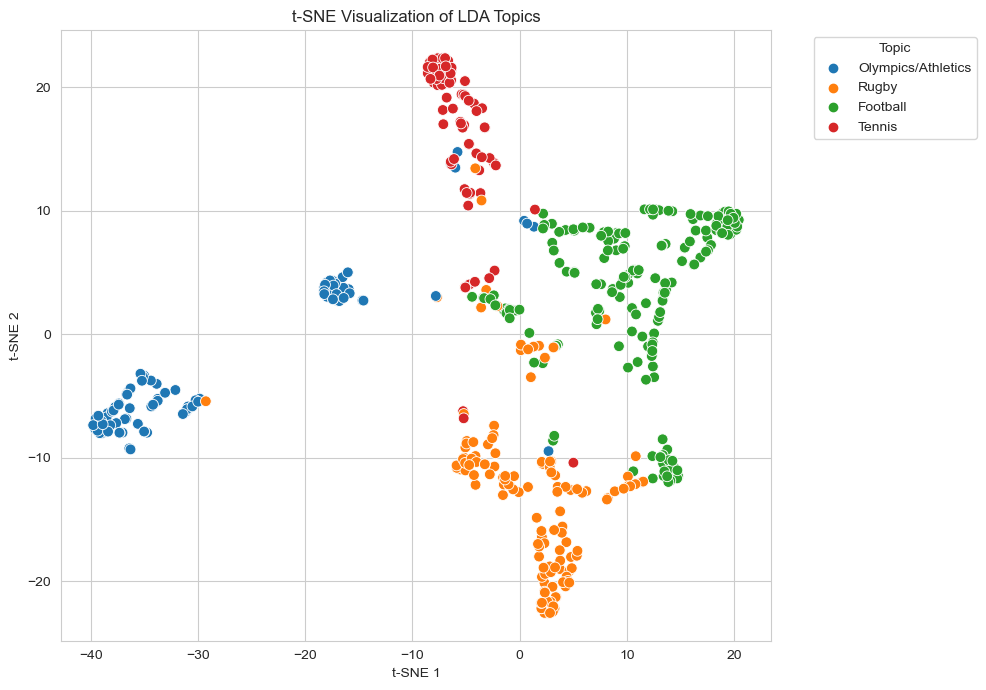

In [165]:
tsne_model = TSNE(n_components=2, perplexity=30, random_state=50, n_iter=1000)
tsne_values = tsne_model.fit_transform(lda_topics)

sports_articles["tsne_x"] = tsne_values[:, 0]
sports_articles["tsne_y"] = tsne_values[:, 1]

# Plot using seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=sports_articles, x="tsne_x", y="tsne_y", hue="LDA_topic", palette="tab10", s=60)

plt.title("t-SNE Visualization of LDA Topics")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

There is clear clustering within the data, which align closely with topics assigned by LDA. There are some 'strays' however these do not necessarily represent inaccuracies, as articles across different sports may contain similarities.

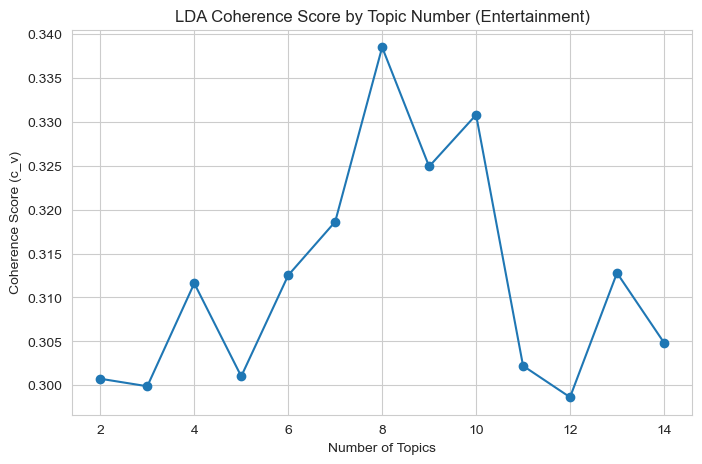

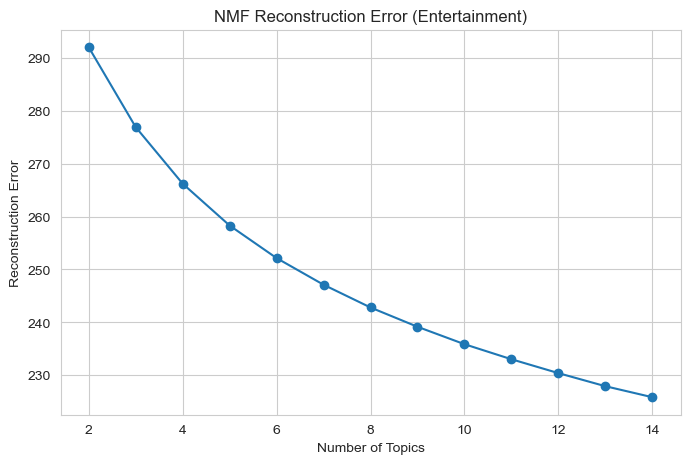

In [30]:
# Repeat for Entertainment articles
entertainment_articles = articles[articles["category"] == "entertainment"].copy()

# Vectorise text
count_vector = CountVectorizer(min_df=0.05, max_df=0.9)
vectorised = count_vector.fit_transform(entertainment_articles["cleaned_text"])
features = count_vector.get_feature_names_out()

# Calculate ideal number of topics for LDA (same method as before)
texts = entertainment_articles["cleaned_text"].apply(lambda x: x.split())
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

coherence_values = []
topic_range = range(2, 15)

for num_topics in topic_range:
    model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=50)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
    coherence_values.append(coherencemodel.get_coherence())

plt.plot(topic_range, coherence_values, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("LDA Coherence Score by Topic Number (Entertainment)")
plt.grid(True)
plt.show()

# And ideal number of topics for NMF
recon_errors = []
for k in topic_range:
    model = NMF(n_components=k, random_state=50)
    W = model.fit_transform(vectorised)
    H = model.components_
    recon_errors.append(model.reconstruction_err_)

plt.plot(topic_range, recon_errors, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Reconstruction Error")
plt.title("NMF Reconstruction Error (Entertainment)")
plt.grid(True)
plt.show()

In [224]:
# Perform LDA (same method as before)
entertainment_articles = articles[articles["category"] == "entertainment"].copy()

count_vector = CountVectorizer(min_df=0.05, max_df=0.9)
vectorised = count_vector.fit_transform(entertainment_articles["cleaned_text"])
features = count_vector.get_feature_names_out()

lda_model = LatentDirichletAllocation(n_components=8, random_state=50)
lda_topics = lda_model.fit_transform(vectorised)
entertainment_articles["LDA_topic"] = lda_topics.argmax(axis=1)

lda_keywords = get_top_keywords(lda_model, features)
for i, topic in enumerate(lda_keywords):
    print(f"Topic {i}: {", ".join(topic)}")

Topic 0: say, star, film, mr, year, make, also, tell, new, would
Topic 1: music, say, band, album, make, like, year, get, people, would
Topic 2: number, top, chart, one, year, single, album, take, release, box
Topic 3: best, award, film, win, oscar, actor, actress, nomination, director, star
Topic 4: film, festival, year, director, award, include, star, actor, book, role
Topic 5: song, year, last, vote, show, best, celebrity, say, win, brother
Topic 6: show, say, tv, bbc, series, new, one, people, programme, also
Topic 7: band, sale, music, year, say, include, singer, concert, sell, fan


In [228]:
# Assign estimated labels
LDA_labels = {
    0 : "Film",
    1 : "Music",
    2 : "Music",
    3 : "Film",
    4 : "Film",
    5 : "Music",
    6 : "TV",
    7 : "Music"}

entertainment_articles["LDA_topic"] = entertainment_articles["LDA_topic"].map(LDA_labels)

In [212]:
#Perform NMF, looking for 8 topics:
nmf_model = NMF(n_components=8, random_state=50)
nmf_topics = nmf_model.fit_transform(vectorised)
entertainment_articles["NMF_topic"] = nmf_topics.argmax(axis=1)

nmf_keywords = get_top_keywords(nmf_model, features)
for i, topic in enumerate(nmf_keywords):
    print(f"Topic {i}: {", ".join(topic)}")

Topic 0: song, best, year, music, last, think, award, vote, win, good
Topic 1: film, festival, year, star, make, movie, oscar, director, award, role
Topic 2: music, black, people, stone, make, good, term, win, award, think
Topic 3: best, award, win, also, prize, name, star, nomination, comedy, ceremony
Topic 4: number, chart, band, top, album, one, single, uk, new, release
Topic 5: show, make, tv, see, would, could, big, child, like, new
Topic 6: say, mr, year, star, show, also, add, work, tell, get
Topic 7: film, actor, director, actress, jamie, aviator, win, scorsese, best, oscar


In [216]:
# Assign estimated labels
NMF_labels = {
    0 : "Music",
    1 : "Film",
    2 : "Music",
    3 : "Film",
    4 : "Music",
    5 : "TV",
    6 : "TV",
    7 : "Film"}

entertainment_articles["NMF_topic"] = entertainment_articles["NMF_topic"].map(NMF_labels)

In [204]:
# Perform Rule-based matching to assess topic labels

# Define entertainment-related keywords
entertainment_keywords = [
    "music", "movie", "film", "tv", "television", "cinema", "oscars", "emmys",
    "grammys", "broadway", "theatre", "concert", "album", "song", "book", "author"]


patterns = [nlp.make_doc(keyword) for keyword in entertainment_keywords]
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
matcher.add("ENTERTAINMENT", patterns)

# Detect keywords in text:
def detect_entertainment_topic(text):
    doc = nlp(text.lower())
    matches = matcher(doc)
    matched_terms = list(set([doc[start:end].text for _, start, end in matches]))
    return matched_terms[0] if matched_terms else "unknown"

entertainment_articles["rbm_topic"] = entertainment_articles["text"].apply(detect_entertainment_topic)



In [220]:
# Compare NMF and LDA topics to keywords:
pd.crosstab(entertainment_articles["NMF_topic"], entertainment_articles["rbm_topic"])

rbm_topic,album,author,book,broadway,cinema,concert,film,grammys,movie,music,song,television,theatre,tv,unknown
NMF_topic,,,,,,,,,,,,,,,
Film,1,0,7,1,0,1,98,2,3,0,2,6,3,3,0
Music,5,0,2,0,0,7,19,4,2,16,19,0,2,5,4
TV,1,1,7,3,1,6,36,0,2,16,12,6,2,41,23


In [210]:
pd.crosstab(entertainment_articles["LDA_topic"], entertainment_articles["rbm_topic"])

rbm_topic,album,author,book,broadway,cinema,concert,film,grammys,movie,music,song,television,theatre,tv,unknown
LDA_topic,,,,,,,,,,,,,,,
Film,3,1,12,3,1,3,117,2,4,8,7,6,5,16,6
Music,4,0,1,0,0,11,28,4,2,21,24,4,2,15,17
TV,0,0,3,1,0,0,8,0,1,3,2,2,0,18,4


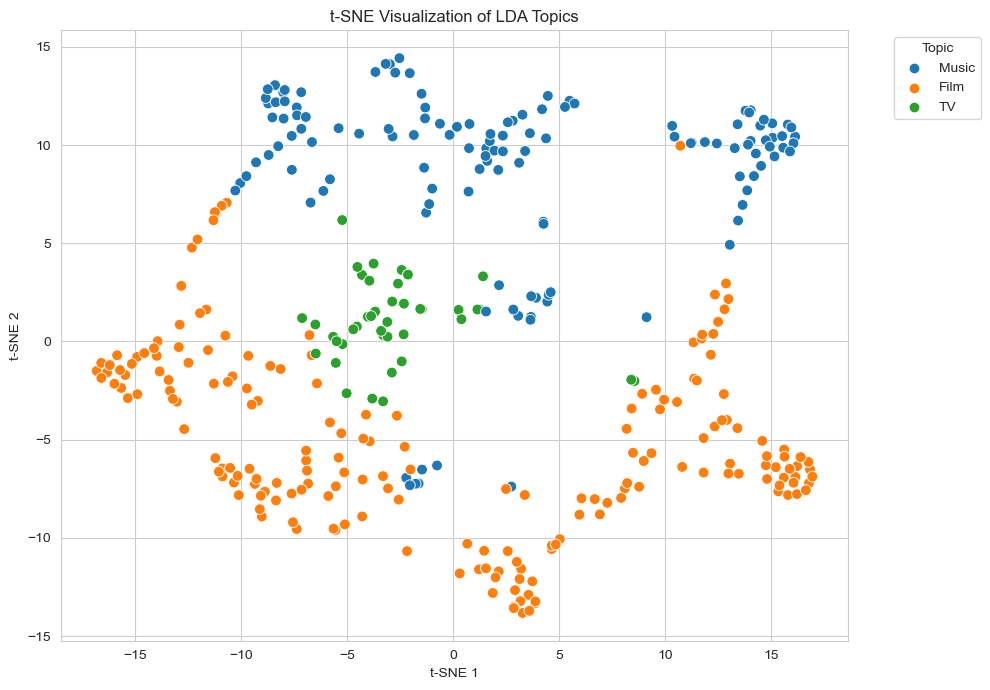

In [230]:
# Visualise using TNSE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=50, n_iter=1000)
tsne_values = tsne_model.fit_transform(lda_topics)

entertainment_articles["tsne_x"] = tsne_values[:, 0]
entertainment_articles["tsne_y"] = tsne_values[:, 1]

# Plot using seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=entertainment_articles, x="tsne_x", y="tsne_y", hue="LDA_topic", palette="tab10", s=60)

plt.title("t-SNE Visualization of LDA Topics")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

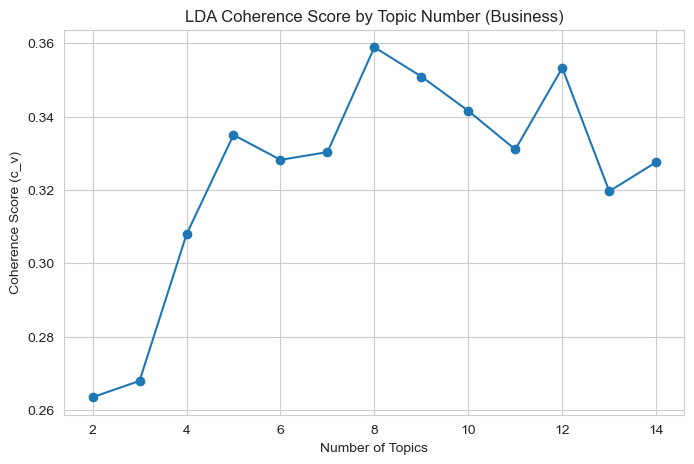

C:\Users\User\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


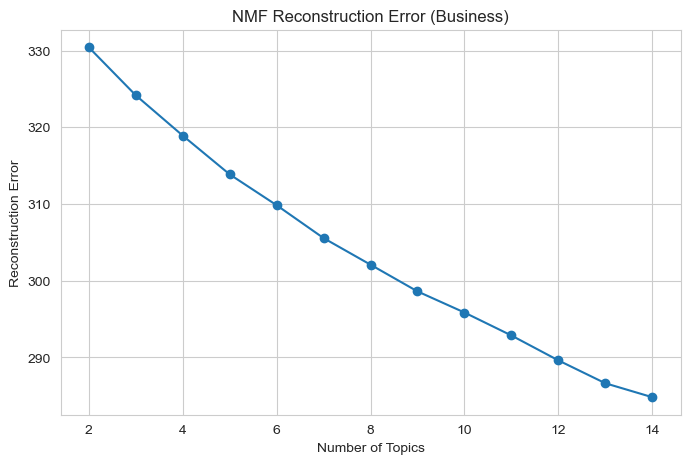

In [37]:
# Repeat for business articles:
business_articles = articles[articles["category"] == "business"].copy()

count_vector = CountVectorizer(min_df=0.05, max_df=0.9)
vectorised = count_vector.fit_transform(business_articles["cleaned_text"])
features = count_vector.get_feature_names_out()

texts = business_articles["cleaned_text"].apply(lambda x: x.split())
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Find optimal number of topics for LDA
coherence_values = []
topic_range = range(2, 15)

for num_topics in topic_range:
    model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=50)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
    coherence_values.append(coherencemodel.get_coherence())

plt.plot(topic_range, coherence_values, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("LDA Coherence Score by Topic Number (Business)")
plt.grid(True)
plt.show()

# Find optimal number of topics for NMF
recon_errors = []
for k in topic_range:
    model = NMF(n_components=k, random_state=50)
    W = model.fit_transform(vectorised)
    H = model.components_
    recon_errors.append(model.reconstruction_err_)

plt.plot(topic_range, recon_errors, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Reconstruction Error")
plt.title("NMF Reconstruction Error (Business)")
plt.grid(True)
plt.show()

In [250]:
# Perform LDA:
count_vector = CountVectorizer(min_df=0.05, max_df=0.9)
vectorised = count_vector.fit_transform(business_articles["cleaned_text"])
features = count_vector.get_feature_names_out()

lda_model = LatentDirichletAllocation(n_components=8, random_state=50)
lda_topics = lda_model.fit_transform(vectorised)
business_articles["LDA_topic"] = lda_topics.argmax(axis=1)

lda_keywords = get_top_keywords(lda_model, features)
for i, topic in enumerate(lda_keywords):
    print(f"Topic {i}: {", ".join(topic)}")

Topic 0: sale, share, company, firm, market, india, new, analyst, uk, stock
Topic 1: rise, rate, year, growth, economy, price, figure, month, market, bank
Topic 2: dollar, euro, airline, year, deficit, budget, cost, fuel, air, currency
Topic 3: bank, mr, government, state, would, united, foreign, investment, tell, rule
Topic 4: year, profit, sale, car, share, firm, company, rise, buy, last
Topic 5: yukos, oil, russian, court, company, russia, china, firm, tax, gas
Topic 6: country, year, economic, world, people, government, economy, 000, job, also
Topic 7: mr, company, firm, bid, share, offer, executive, would, chief, shareholder


In [251]:
# Assign estimated labels
LDA_labels = {
    0 : "Stock Market",
    1 : "Economics",
    2 : "Company News",
    3 : "Economics",
    4 : "Company News",
    5 : "Company News",
    6 : "Economics",
    7 : "Mergers & Acquisitions"}

business_articles["LDA_topic"] = business_articles["LDA_topic"].map(LDA_labels)

In [39]:
#Perform NMF, looking for 7 topics:
nmf_model = NMF(n_components=7, random_state=50)
nmf_topics = nmf_model.fit_transform(vectorised)
business_articles["NMF_topic"] = nmf_topics.argmax(axis=1)

nmf_keywords = get_top_keywords(nmf_model, features)
for i, topic in enumerate(nmf_keywords):
    print(f"Topic {i}: {", ".join(topic)}")

Topic 0: sale, year, profit, car, rise, expect, last, euro, 000, december
Topic 1: share, company, firm, market, would, stock, offer, make, deal, exchange
Topic 2: yukos, oil, russian, company, court, tax, russia, firm, bankruptcy, state
Topic 3: year, country, economic, economy, government, growth, world, budget, also, deficit
Topic 4: mr, united, fraud, tell, chief, proposal, company, year, former, new
Topic 5: bank, china, standard, big, south, one, loan, two, make, new
Topic 6: price, rise, rate, market, growth, month, year, economy, fall, figure


In [238]:
# Assign estimated labels
NMF_labels = {
    0 : "Company News",
    1 : "Stock Market",
    2 : "Company News",
    3 : "Economics",
    4 : "Company News",
    5 : "Company News",
    6 : "Stock Market"}

business_articles["NMF_topic"] = business_articles["NMF_topic"].map(LDA_labels)

In [242]:
# Define business keywords
business_keywords = ["economy", "finance", "stock market", "stocks", "shares", "merger", "acquistion", "company", "market", "gdp"]

patterns = [nlp.make_doc(keyword) for keyword in business_keywords]
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
matcher.add("BUSINESS", patterns)

# Detect keywords:
def detect_business_topic(text):
    doc = nlp(text.lower())
    matches = matcher(doc)
    matched_terms = list(set([doc[start:end].text for _, start, end in matches]))
    return matched_terms[0] if matched_terms else "unknown"

business_articles["rbm_topic"] = business_articles["text"].apply(detect_business_topic)


In [243]:
pd.crosstab(business_articles["NMF_topic"], business_articles["rbm_topic"])

rbm_topic,company,economy,finance,gdp,market,merger,shares,stock market,stocks,unknown
NMF_topic,,,,,,,,,,
Company News,26,12,13,0,30,3,38,1,0,19
Economics,23,64,7,2,96,3,70,4,2,49
Stock Market,10,1,1,0,11,0,15,0,0,3


In [244]:
pd.crosstab(business_articles["LDA_topic"], business_articles["rbm_topic"])

rbm_topic,company,economy,finance,gdp,market,merger,shares,stock market,stocks,unknown
LDA_topic,,,,,,,,,,
Company News,22,15,11,1,42,0,37,3,0,14
Economics,20,60,6,1,65,2,18,1,2,45
Mergers & Acquisitions,15,0,4,0,17,4,39,0,0,8
Stock Market,2,2,0,0,13,0,29,1,0,4


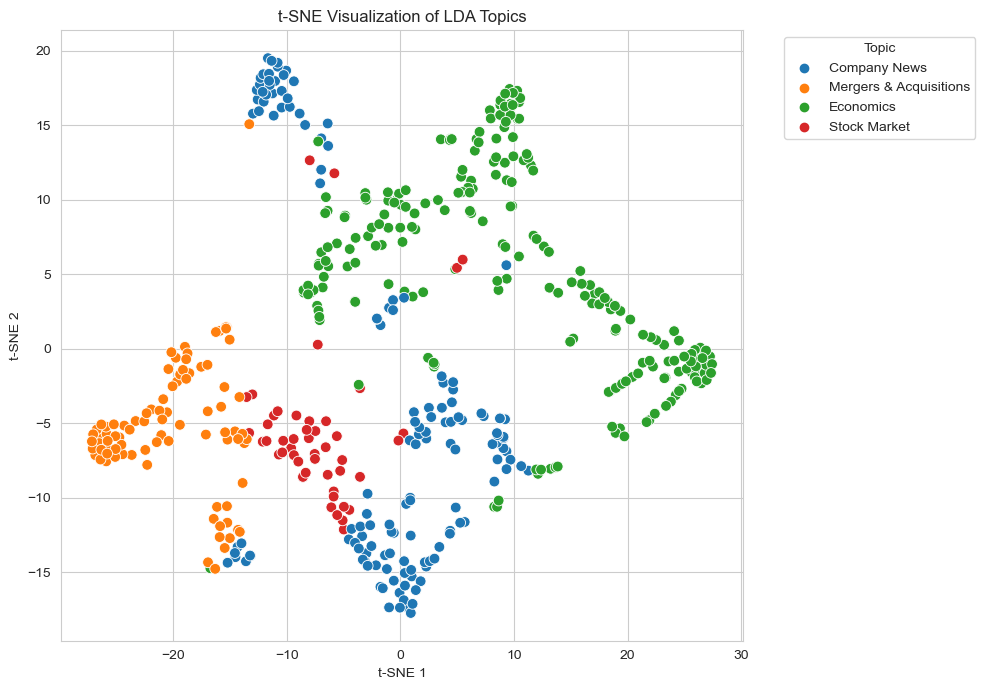

In [254]:
# Visualise using TNSE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=50, n_iter=1000)
tsne_values = tsne_model.fit_transform(lda_topics)

business_articles["tsne_x"] = tsne_values[:, 0]
business_articles["tsne_y"] = tsne_values[:, 1]

# Plot using seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=business_articles, x="tsne_x", y="tsne_y", hue="LDA_topic", palette="tab10", s=60)

plt.title("t-SNE Visualization of LDA Topics")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# Desirable

* Extract summaries of anything that took place or is/was scheduled to take place in April.

In [256]:
# Extract articles with a mention of April
april_articles = articles[articles["text"].str.contains("April|Apr", case=False, na=False)]
april_articles.head()

,text,category,num_words,num_sentences,num_stopwords,cleaned_text,textRank_summary
12,Peugeot deal boosts Mitsubishi\n\nStruggling J...,business,336,14,144,peugeot deal boost mitsubishi struggle japanes...,Falling sales have left Mitsubishi Motors with...
33,"Rover deal 'may cost 2,000 jobs'\n\nSome 2,000...",business,349,14,159,"rover deal 'may cost 2,000 jobs' 2,000 job mg ...",Shanghai Automotive Industry Corp plans to shi...
70,Japan turns to beer alternatives\n\nJapanese b...,business,251,10,118,japan turn beer alternative japanese brewer in...,"Now, according to Asahi Breweries, the market ..."
79,"Argentina, Venezuela in oil deal\n\nArgentina ...",business,217,11,81,argentina venezuela oil deal argentina venezue...,Argentina and Venezuela have extended a food-f...
97,IMF 'cuts' German growth estimate\n\nThe Inter...,business,253,10,119,imf 'cuts german growth estimate international...,The IMF will also reduce its growth estimate f...


In [258]:
april_articles["textRank_summary"]

12      Falling sales have left Mitsubishi Motors with...
33      Shanghai Automotive Industry Corp plans to shi...
70      Now, according to Asahi Breweries, the market ...
79      Argentina and Venezuela have extended a food-f...
97      The IMF will also reduce its growth estimate f...
                              ...                        
1968    "We looked at more of the independent musician...
1997    "We are proud of it because it has the sound q...
2007    But she did not, because having fast, always o...
2087    The rest of the world was also falling in love...
2098    Ofcom wants to ensure that the arrival of UWB-...
Name: textRank_summary, Length: 124, dtype: object

* Identify documents and extract the named entities for media personalities, clearly identifying their jobs (e.g. Politicians, TV/Film Personalities, Musicians)

In [50]:
# Utilise rule-based matching to extract names and jobs:

# Load spaCy model
nlp = spacy.load("en_core_web_trf")

# Define jobs:
media_jobs = [
    "journalist", "reporter", "presenter", "anchor", "correspondent", "editor",
    "newsreader", "host", "commentator", "columnist", "broadcaster", "media personality", 
    "policitian", "mp", "musician", "guitarist", "drummer", "singer", "director", "actor", 
    "actress", "director", "dj", "producer", "pm", "prime minister"]

# Regex to match job titles
job_title_pattern = re.compile(r"\b(" + "|".join(media_jobs) + r")s?\b", re.IGNORECASE)

# Function to extract name and job title from a text
def extract_media_personalities(text):
    doc = nlp(text)
    results = []

    for ent in doc.ents:
        if ent.label_ == "PERSON":
            name = ent.text.strip()
            sentence = ent.sent.text  # Get the full sentence containing the name
            job_matches = job_title_pattern.findall(sentence)
            for job in job_matches:
                results.append((name, job.lower()))
    return results

# Extract names and jobs from each article
all_personalities = []

for article in articles["text"]:
    results = extract_media_personalities(article)
    all_personalities.extend(results)

# Remove duplicates:
all_personalities = set(all_personalities)

# Print results
for name, job in all_personalities:
    print(f"{name}: {job}")


, Ken Macdonald QC: director
50 Cent's: editor
AL Gooneratne: director
AR Rahman: director
Aaliyah: producer
Aamir Khan: actor
Aamir Khan: producer
Abbas: prime minister
Abdellatif Kechiche: actress
Abdellatif Kechiche: director
Abdullatif Sener: prime minister
Aburizal Bakrie: reporter
Adam Curry: host
Adam Vaughan: editor
Adams: actor
Adams: producer
Adarsh: actor
Adrian Hosford: director
Adrian Palmer: director
Aguilera: singer
Aishwarya Rai: actor
Akira Hurosawa: director
Akira Kurosawa: director
Al Jolson: actor
Al Jolson: singer
Alan Alda: actor
Alan Bennett: actor
Alan Bennett: actress
Alan Bennett: director
Alan Bennett: producer
Alan Bennett: singer
Alan Johnson: mp
Alan Milburn: prime minister
Alan Parker: director
Alan Wass: musician
Alan Wass: singer
Alan White: drummer
Alan White: singer
Alastair Campbell: director
Alastair Campbell: journalist
Alastair Campbell: prime minister
Alastair Sibbald: director
Alejandro Amenabar: director
Alex Kapranos: guitarist
Alex Kapranos: 